# Loss functions 

This notebook showcases and explains the various loss functions in `unipercept.nn.losses`.

In [1]:
import unipercept as up
import torch
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

print(f"Using UniPercept version {up.__version__}")

AttributeError: module 'unipercept' has no attribute '__version__'

## Sigmoid focal loss

Using the variant from *RetinaNet: [...]*, focal loss defines a weighted loss of class-level object detections.

In [ ]:
focal_loss = up.nn.losses.SigmoidFocalLoss(alpha=0.0, gamma=1.0)

print(f"FocalLoss module: {focal_loss}")

FocalLoss module: SigmoidFocalLoss()


## Depth loss

Depth loss combines scale-invariant logarithmic error (SILE) and absolute relative error (ARE) into a weighted loss 
function that balances relative error with pixel-to-pixel accuracy.

In [ ]:
depth_loss = up.nn.losses.DepthLoss()

print(f"DepthLoss module: {depth_loss}")

DepthLoss module: DepthLoss()


Implementations of the depth errors as loss functions are often subject to numerical instability. In `unipercept`, we 
have taken some steps to combat this, and the next cells motivate the relevant design choices.

## Depth-guided panoptic (DGP) loss


In [ ]:
batch_size = 4
num_classes = 20
height = 64
width = 128
panoptic_features = torch.randn(batch_size, num_classes, height, width)
true_depth = torch.randn(batch_size, height, width)

dgp_loss = up.nn.losses.DGPLoss()

print(f"DGP module: {dgp_loss}")


DGP module: DGPLoss()


## Panoptic-guided triplet (PGT) loss

Shows an example of PGT loss, see: Petrovai et al., *MonoDVPS: [...]* (WACV 2022)

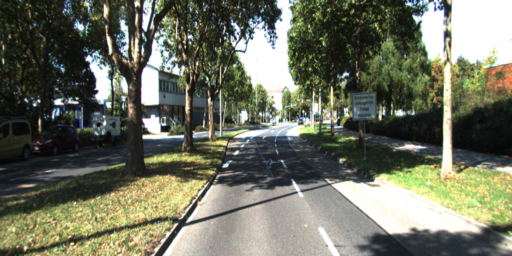

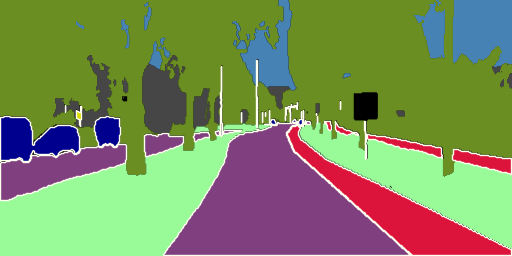

ValueError: Could not save to JPEG for display

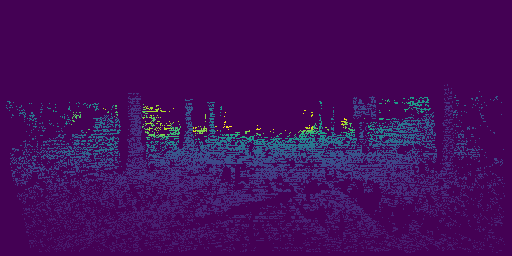

In [ ]:
import torch
import unipercept as up
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import torchvision.transforms.v2 as transforms
info = up.get_info("kitti-step")

depth = up.data.tensors.DepthMap.read("../assets/sample-annotated/depth.png", format=up.data.tensors.DepthFormat.DEPTH_INT16)
panseg = up.data.tensors.PanopticMap.read("../assets/sample-annotated/segmentation.png", info, format=up.data.tensors.LabelsFormat.KITTI)
image = up.data.io.read_image("../assets/sample-annotated/image.png")

tf = transforms.Resize((256, 512), antialias=True)
depth = tf(depth)
panseg = tf(panseg)
image = tf(image)

display(HTML("<h3>Images</h3>"))
display(up.render.draw_image(image))
display(up.render.draw_image_segmentation(panseg, info=info))
display(up.render.draw_image_depth(depth, info=info))

pass

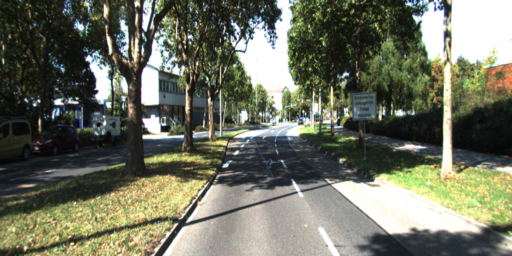

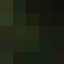

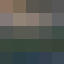

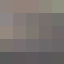

In [ ]:
import functools
import torch.nn as nn
import torch

display(up.render.draw_image(image))

for tensor in (image, depth, panseg):
    while tensor.ndim < 4:
        tensor.unsqueeze_(0)

split_fn = functools.partial(up.nn.losses.functional.split_into_patches, sizes=(5,5), strides=(5,5))

image_patches = split_fn(image) 
depth_patches = split_fn(depth)
panseg_patches = split_fn(panseg)

NUM_EXAMPLES = 3

display(HTML(f"<p>Image is split into patches ({image_patches.shape}), showing {NUM_EXAMPLES} examples: </p>"))
for i in torch.linspace(0,image_patches.shape[2]-1, NUM_EXAMPLES):
    i = int(i)
    p = image_patches[0, :, i, :, :]
    p = transforms.functional.resize(p, (64,64), interpolation=transforms.InterpolationMode.NEAREST, antialias=False)
    display(up.render.draw_image(p))


##### Visualizing the PGT loss over a grid

In [ ]:
depth_features = torch.randn(1, 32, *depth.shape[-2:]) * depth
panseg_true = panseg

print(f"{depth_features.shape=}")
print(f"{panseg_true.shape=}")

loss, mask = up.nn.losses.functional.segmentation_guided_triplet_loss(depth_features, panseg_true, 0.25, 5, 5, 5)

print(f"{loss.shape=}")
print(f"{mask.shape=}")
print(torch.masked_select(loss, mask))


loss = loss.view(1, 32, -1, 5, 5)
print(loss.shape)

depth_features.shape=torch.Size([1, 32, 256, 512])
panseg_true.shape=torch.Size([1, 1, 256, 512])
loss.shape=torch.Size([1, 32, 32004])
mask.shape=torch.Size([1, 1, 32004])
tensor([0.2500, 0.2500, 0.2500,  ..., 0.0000, 0.0434, 0.0000])


RuntimeError: shape '[1, 32, -1, 5, 5]' is invalid for input of size 1024128

2023-11-28 17:29:17 📝 unipercept.engine: Initializing Engine: multidvps @ cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl
2023-11-28 17:29:17 📝 unipercept.engine: Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl


2023-11-28 17:29:17 📝 unipercept.engine: Current process: 1 / 1
2023-11-28 17:29:19 📝 unipercept.engine: Recovered engine state at step 30000
Recovered model from training session
2023-11-28 17:29:19 📝 unipercept.data: Wrapping dataset: CityscapesVPSDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='val', root='//datasets/cityscapes-vps', all=False)
ModelOutput(
    losses=LazyStackedTensorDict(
        fields={
        },
        exclusive_fields={
        },
        batch_size=torch.Size([1]),
        device=cpu,
        is_shared=False,
        stack_dim=0),
    metrics=LazyStackedTensorDict(
        fields={
        },
        exclusive_fields={
        },
        batch_size=torch.Size([1]),
        device=cpu,
        is_shared=False,
        stack_dim=0),
    predictions=LazyStackedTensorDict(
        fields={
            backgrounds: StuffInstances(
                categories=Tensor(shape=torch.Size([1, 13]), device=cpu, dtype=torch.int64, is_shared=Fa

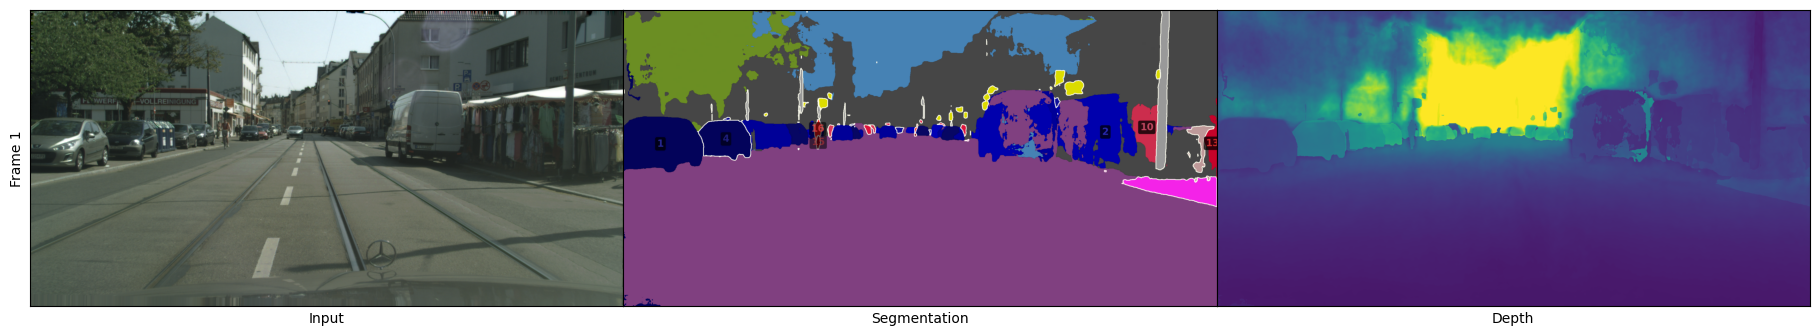

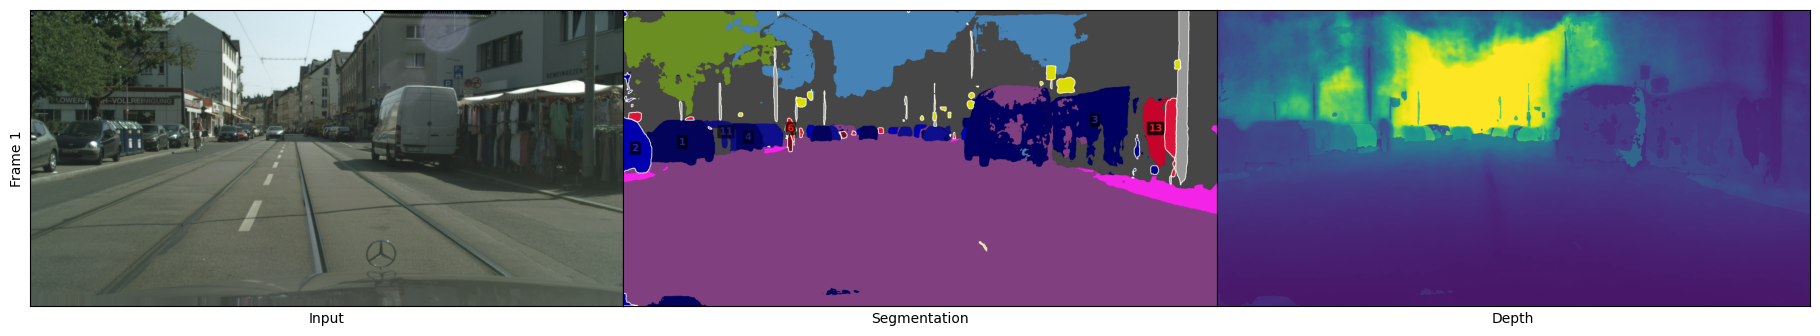

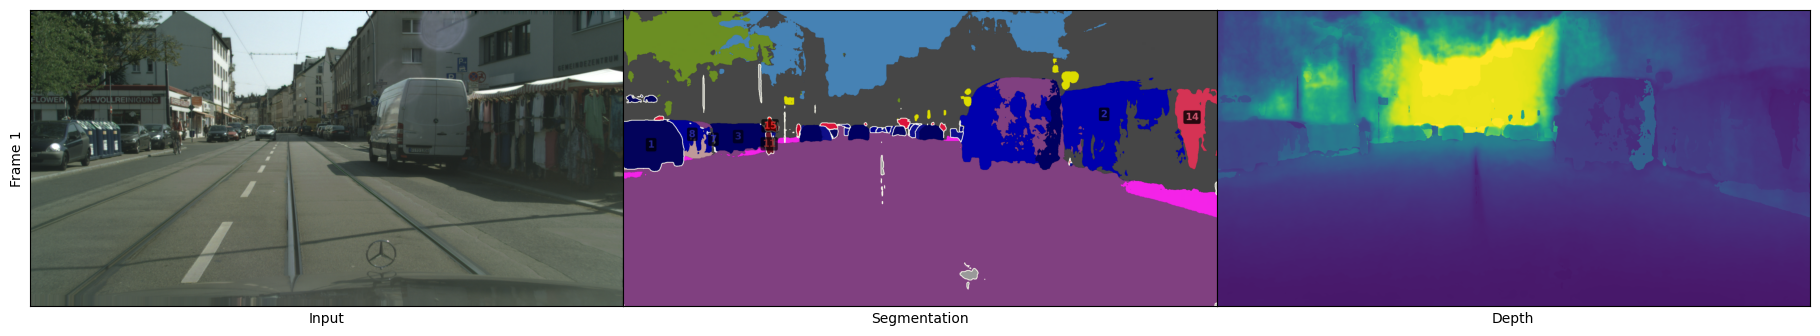

In [5]:
import unipercept as up

config = up.read_config("../outputs/multidvps/cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl/config.yaml")

model = up.create_model(config, device="cuda")
model.eval()
ds, info = up.create_dataset(config, "test")

for n, inputs in enumerate(ds):
    if n > 2:
        break
    with torch.no_grad():
        inputs = inputs.cuda()
        outputs = model(inputs).cpu()
        inputs = inputs.cpu()

    print(outputs)

    up.render.plot_predictions(inputs, outputs, info=info)

